In [1]:
# load modules
import os
import numpy as np
import pandas as pd
import pickle

# Plotting imports
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

import palantir
import scanpy.api as sc
sc.settings.verbosity = 5

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
import random
random.seed(100)

In [3]:
%matplotlib inline

## Download data

Anndata objects with all the data and metadata are publically avaiable at: https://s3.amazonaws.com/dp-lab-data-public/palantir/human_cd34_bm_rep[1-3].h5ad. This notebook use replicate 1 (https://s3.amazonaws.com/dp-lab-data-public/palantir/human_cd34_bm_rep1.h5ad) for illustration. 

Description of the anndata object is available at https://s3.amazonaws.com/dp-lab-data-public/palantir/readme

## Load data

In [4]:
# Load the AnnData object
ad = sc.read('annadata/human_cd34_bm_rep1.h5ad')
colors = pd.Series(ad.uns['cluster_colors'])
ct_colors = pd.Series(ad.uns['ct_colors'])

## Slingshot

The following genes were used to determine trends

In [5]:
genes = ['CD79B',
 'SPI1',
 'RAG1',
 'CD34',
 'CEBPG',
 'GATA1',
 'ITGA2B',
 'CD79A',
 'IRF8',
 'CSF1R',
 'MPO',
 'CEBPD']

Multi-scale was computed as described in the sample notebook. Let this object be represented as ```ms_data```

We export the multi-scale data, clusters and gene expression for the above genes and use the Slingshot R Script to compute the results. The exporting code is shown below

```
# Export data 
slignshot_dir = 'slingshot/'
os.makedirs(slignshot_dir, exist_ok=True)

# Genes
# Expression matrices
pd.DataFrame(ms_data).to_csv(f'{slignshot_dir}/data.csv', index=None, header=None)
pd.DataFrame(ad.obs['clusters']).to_csv(f'{slignshot_dir}/clusters.csv', index=None, header=None)
pd.DataFrame(ad[:, genes].X.T, index=genes, columns=ad.obs_names).to_csv(f'{slignshot_dir}/exprs.csv')
```

R snippet used is shown below was saved as ```slingshot_wrapper.R```

```
library(slingshot)

args <- commandArgs(trailingOnly = TRUE)
out_dir <- args[1]

# Load data
data = read.csv(sprintf("%s/data.csv", out_dir), header=FALSE)
clusters = read.csv(sprintf("%s/clusters.csv", out_dir), header=FALSE)[, 1]
exprs = read.csv(sprintf("%s/exprs.csv", out_dir), row.names=1)


# Slingshot
print('Lineages...')
lin1 <- getLineages(data, clusters, start.clus = 0)
print('Curves...')
crv1 <- getCurves(lin1)
print('Pseudotime...')
pst <- slingPseudotime(crv1)
w <- slingCurveWeights(crv1)
L <- length(slingLineages(crv1))

write.csv(w, sprintf("%s/weights.csv", out_dir))

# Trends for each lineage
print('Gene trends...')
for(l in seq_len(L)){
    print(sprintf("Lineage: %d", l))

    for(gene in rownames(exprs)){
        print(sprintf("Gene: %s", gene))
        y <- exprs[gene, ]
        p <- loess(unlist(y) ~ pst[,l], weights = w[,l])
        pl = predict(p, se=TRUE)
        df = cbind(p$x, p$fitted, qt(0.975,pl$df)*pl$se)
        colnames(df) <- c('Trajectory', 'trends', 'ci')
        write.csv(df, sprintf("%s/Lineage%d_%s.csv", out_dir, l, gene))
    }
}

```

The above script was invoked as shown below

```
import subprocess

ss_path = 'slingshot/slingshot_wrapper.R'
args = f'Rscript {ss_path} {out_dir}'
print('Running Slingshot using: {}\n'.format(args))
with subprocess.Popen(args,
                      stdout=None, stderr=subprocess.PIPE,
                      shell=True) as p:
    out, err = p.communicate()


```

The results from the above run is available at ```results/slingshot```

### Load results

In [6]:
import glob
res_dir = 'results/slingshot/'
files = glob.glob(res_dir + 'Lin*.csv')
lineages = pd.Series(files).str.split('/').str.get(-1).str.split('_').str.get(0).unique()

In [7]:
# Update trajectory 
max_traj = -np.inf
min_traj = np.inf
trends = pd.Series()
for l in lineages:
    trends[l] = pd.Series()
    for gene in genes:
        trends[l][gene] = pd.read_csv(f'{res_dir}{l}_{gene}.csv', index_col=0 )
        if max_traj < trends[l][gene]['Trajectory'].max():
            max_traj = trends[l][gene]['Trajectory'].max()
        if min_traj > trends[l][gene]['Trajectory'].min():
            min_traj = trends[l][gene]['Trajectory'].min()            

In [8]:
vmin = np.inf; vmax = -np.inf;
for l in lineages:
    pt = trends[l][gene].Trajectory
    vmin = np.min([vmin, pt.min()])
    vmax = np.max([vmax, pt.max()])

tSNE map generated using PCA was used in the manuscript. The results are shown below with tSNE generated using scaled diffusion components

In [9]:
tsne = pd.DataFrame(ad.obsm['tsne'], index=ad.obs_names, columns=['x', 'y'])

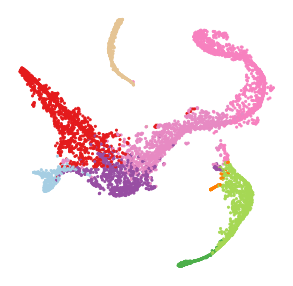

In [10]:
plt.figure(figsize=[5, 5])
plt.scatter(tsne.loc[:, 'x'], tsne.loc[:, 'y'], s=5, 
           color=colors[ad.obs['clusters']])
ax = plt.gca()
ax.set_axis_off()



### Lineage cells 

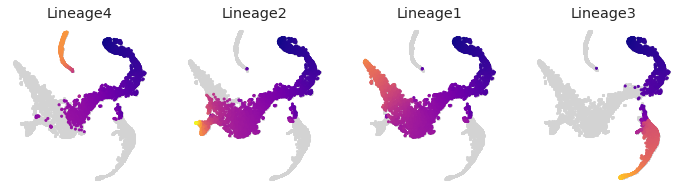

In [11]:
fig = palantir.plot.FigureGrid(len(lineages), len(lineages))
for ax, l in zip(fig, lineages):
    pt = trends[l][gene].Trajectory
    ax.scatter(tsne.loc[:, 'x'], tsne.loc[:, 'y'], s=5, color='lightgrey')
    ax.scatter(tsne.loc[pt.index, 'x'],
              tsne.loc[pt.index, 'y'], s=5, c=pt, 
    cmap=matplotlib.cm.plasma, vmin=vmin, vmax=vmax)
    ax.set_axis_off()
    ax.set_title(l)

### Weights

In [12]:
weights =  pd.read_csv(f'{res_dir}/weights.csv', index_col=0)
weights.index = ad.obs_names
weights.columns = lineages

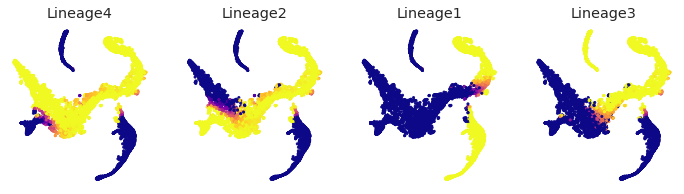

In [13]:
fig = palantir.plot.FigureGrid(len(lineages), len(lineages))
for ax, l in zip(fig, lineages):
    ax.scatter(tsne.loc[weights.index, 'x'],
              tsne.loc[weights.index, 'y'], s=5, c=weights.loc[:, l],
    cmap=matplotlib.cm.plasma)
    ax.set_axis_off()
    ax.set_title(l)

### Trends

In [14]:
lin_colors = pd.Series()
lin_colors['Lineage1'] = ct_colors['Mono']
lin_colors['Lineage2'] = ct_colors['DC']
lin_colors['Lineage3'] = ct_colors['Ery']
lin_colors['Lineage4'] = ct_colors['CLP']

In [15]:
from matplotlib.ticker import FormatStrFormatter

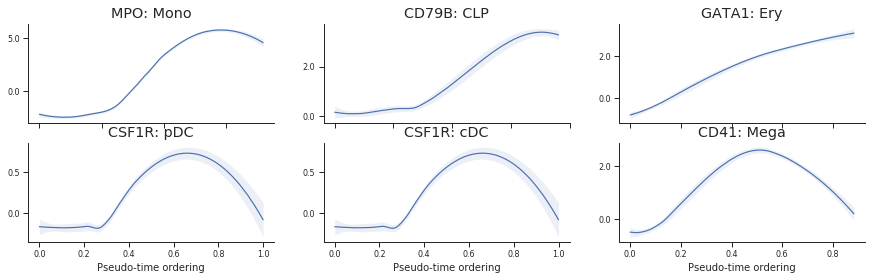

In [16]:
genes = ['MPO', 'CD79B', 'GATA1', 'CSF1R', 'CSF1R', 'ITGA2B']
labels = ['MPO', 'CD79B', 'GATA1', 'CSF1R', 'CSF1R', 'CD41']

gene_lineages = ['Lineage1', 'Lineage4', 'Lineage3',  'Lineage2', 'Lineage2', 'Lineage3',]
gene_branches = ['Mono', 'CLP', 'Ery',  'pDC', 'cDC', 'Mega',]



fig = plt.figure(figsize=[5*3, 2 * 2])
i = 1

for gene, label, l, branch in zip(genes, labels, gene_lineages, gene_branches):
    ax = fig.add_subplot(2, 3, i); i = i + 1
    
    # Slingshot
    order = trends[l][gene].Trajectory.sort_values().index
    bins = np.ravel(trends[l][gene].Trajectory[order])
    bins = (bins - min_traj) / (max_traj - min_traj)
    t = np.ravel(trends[l][gene].trends[order])
    stds = np.ravel(trends[l][gene].ci[order])

    # Plot
    ax.plot(bins, t)#, color=lin_colors[l])
    ax.fill_between(bins, (t - stds),
            (t + stds), alpha=0.1)#, color=lin_colors[l])
    ax.set_title(f'{label}: {branch}')
    
    if i < 5 :
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Pseudo-time ordering', fontsize=10)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    
sns.despine()